Try to load a real data set from causal-learn and use PC algorithm

This code is copied from https://github.com/py-why/causal-learn/blob/main/tests/TestGraphVisualization.py, developped by Toby Stains, and adapted to work in a notebook.

In [31]:
import sys

sys.path.append("")

import io
import unittest
from itertools import product

import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from causallearn.graph.Dag import Dag
from causallearn.graph.Edge import Edge
from causallearn.graph.Endpoint import Endpoint
from causallearn.graph.GeneralGraph import GeneralGraph
from causallearn.graph.GraphNode import GraphNode
from causallearn.search.ConstraintBased.PC import pc
from causallearn.search.Granger.Granger import Granger
from causallearn.utils.cit import fisherz
from causallearn.utils.DAG2PAG import dag2pag
from causallearn.utils.GraphUtils import GraphUtils
from causallearn.utils.TimeseriesVisualization import plot_time_series
from causallearn.utils.PCUtils.BackgroundKnowledge import BackgroundKnowledge
from causallearn.utils.PCUtils.BackgroundKnowledgeOrientUtils import \
    orient_by_background_knowledge

In [55]:
data_path = "traffic_data.csv"
data_traff_df = pd.read_csv(data_path, skiprows=0)  # Import the file at data_path as data

In [56]:
data_traff_df.shape

(132622, 31)

In [42]:
data_traff_df.dtypes

Local_Authority_(District)                      object
Accident_Count                                   int64
Number_of_Casualties                             int64
Serious                                         object
Fatal                                           object
Date                                            object
Day_of_Week                                     object
Hour                                             int64
Light_Conditions_Darkness - lighting unknown      bool
Light_Conditions_Darkness - lights lit            bool
Light_Conditions_Darkness - lights unlit          bool
Light_Conditions_Darkness - no lighting           bool
Light_Conditions_Daylight                         bool
Weather_Conditions_Fine + high winds              bool
Weather_Conditions_Fine no high winds             bool
Weather_Conditions_Fog or mist                    bool
Weather_Conditions_Other                          bool
Weather_Conditions_Raining + high winds           bool
Weather_Co

In [60]:
print(data_traff_df.Date.min())
print(data_traff_df.Date.max())

2016-01-01
2016-12-31


In [43]:
data_traff_df.head()

,Local_Authority_(District),Accident_Count,Number_of_Casualties,Serious,Fatal,Date,Day_of_Week,Hour,Light_Conditions_Darkness - lighting unknown,Light_Conditions_Darkness - lights lit,...,Road_Surface_Conditions_Dry,Road_Surface_Conditions_Flood over 3cm. deep,Road_Surface_Conditions_Frost or ice,Road_Surface_Conditions_Snow,Road_Surface_Conditions_Wet or damp,Alt_Road_Class_A Rural,Alt_Road_Class_A Urban,Alt_Road_Class_Minor Rural,Alt_Road_Class_Minor Urban,Alt_Road_Class_Motorway
0,Brent,1,1,0,0,2016-11-01,Tuesday,2,False,False,...,True,False,False,False,False,False,True,False,False,False
1,Bexley,1,1,0,0,2016-11-01,Tuesday,0,False,True,...,True,False,False,False,False,False,True,False,False,False
2,Hillingdon,1,1,0,0,2016-11-01,Tuesday,1,False,True,...,True,False,False,False,False,False,True,False,False,False
3,Merton,1,1,0,0,2016-11-01,Tuesday,9,False,False,...,True,False,False,False,False,False,True,False,False,False
4,Hounslow,1,1,0,0,2016-11-01,Tuesday,7,False,False,...,True,False,False,False,False,False,True,False,False,False


We will convert "Fatal" to a binary value.

In [44]:
def binary_fatality(fatal):
    if fatal in ["0","False"]:
        return 0
    else:
        return 1

In [45]:
data_traff_df.Fatal = data_traff_df["Fatal"].apply(binary_fatality)

We want to remove some columns.

In [46]:
cols = []
for c in data_traff_df.columns :
 #   data_traff_df = data_traff_df[]
    if c not in ["Local_Authority_(District)","Date","Day_of_Week","Serious","Accident_Count"]:
        cols.append(c)


In [47]:
data_traff_df = data_traff_df[cols]

We convert all bools into integers.

In [48]:
data_traff_df = data_traff_df.astype(int)

In [49]:
data_traff_df.dtypes[:20]

Number_of_Casualties                            int32
Fatal                                           int32
Hour                                            int32
Light_Conditions_Darkness - lighting unknown    int32
Light_Conditions_Darkness - lights lit          int32
Light_Conditions_Darkness - lights unlit        int32
Light_Conditions_Darkness - no lighting         int32
Light_Conditions_Daylight                       int32
Weather_Conditions_Fine + high winds            int32
Weather_Conditions_Fine no high winds           int32
Weather_Conditions_Fog or mist                  int32
Weather_Conditions_Other                        int32
Weather_Conditions_Raining + high winds         int32
Weather_Conditions_Raining no high winds        int32
Weather_Conditions_Snowing + high winds         int32
Weather_Conditions_Snowing no high winds        int32
Road_Surface_Conditions_Dry                     int32
Road_Surface_Conditions_Flood over 3cm. deep    int32
Road_Surface_Conditions_Fros

C:\Users\frlegoff\Anaconda3\lib\site-packages\numpy\lib\function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\Users\frlegoff\Anaconda3\lib\site-packages\numpy\lib\function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


  0%|          | 0/15 [00:00<?, ?it/s]

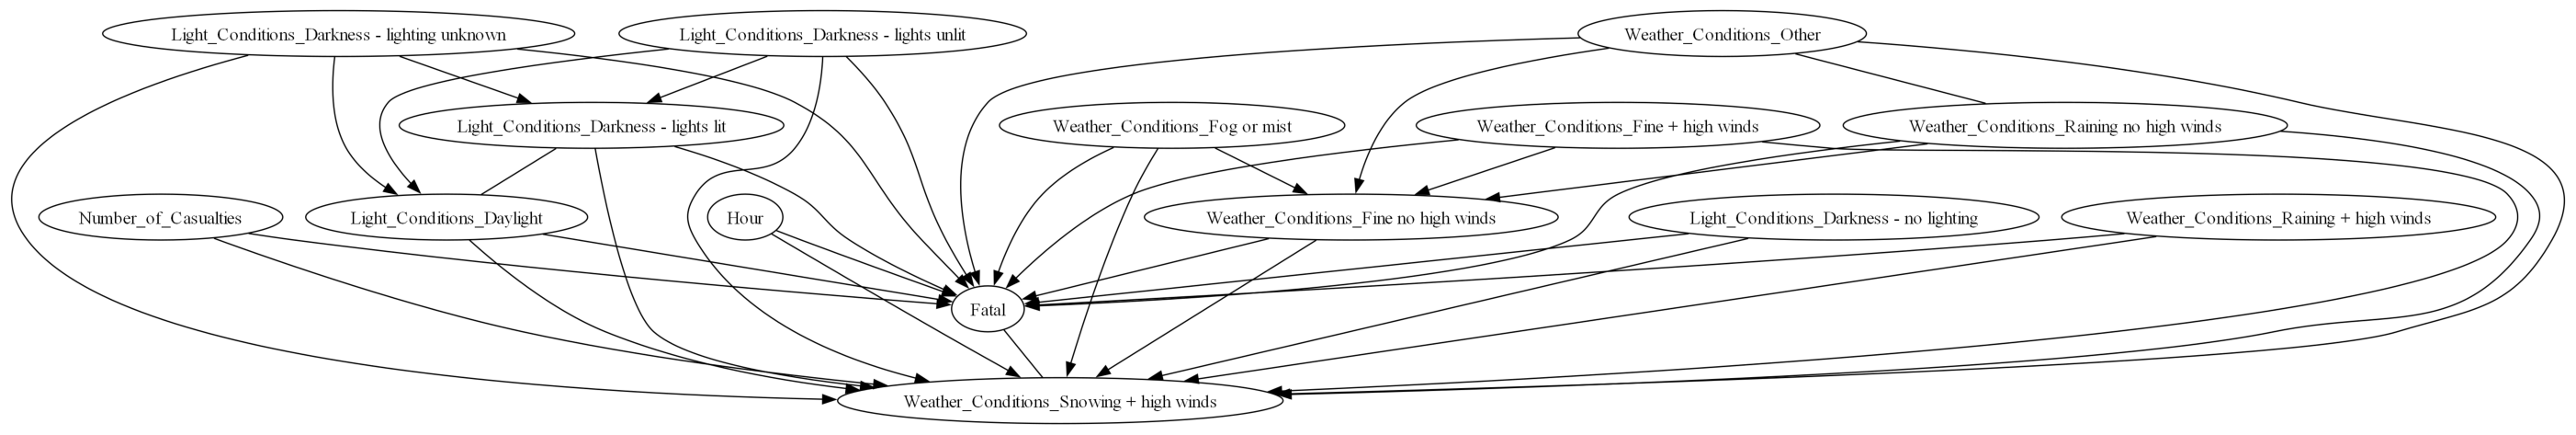

finish
CPU times: total: 1min
Wall time: 1min


In [50]:
%%time
cg = pc(data_traff_df.dropna().values[:700,:15], 0.05, fisherz, True, 0,-1)  # Run PC and obtain the estimated graph (CausalGraph object)
pyd = GraphUtils.to_pydot(cg.G, labels=data_traff_df.columns[:15])
tmp_png = pyd.create_png(f="png")
fp = io.BytesIO(tmp_png)
img = mpimg.imread(fp, format='png')
plt.figure(figsize = (50,50))
plt.axis('off')
plt.imshow(img)
plt.show()
print('finish')

  0%|          | 0/9 [00:00<?, ?it/s]

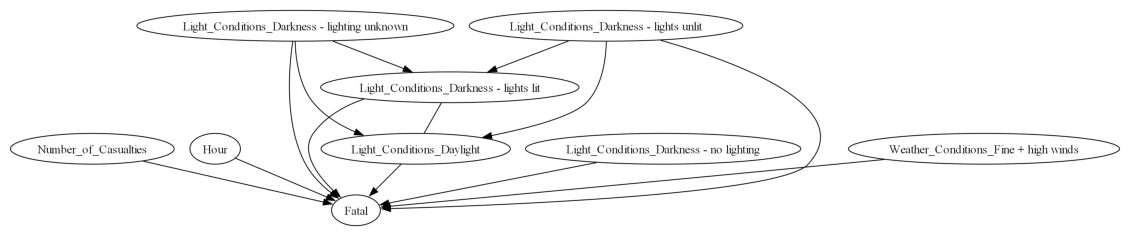

finish
CPU times: total: 2.19 s
Wall time: 1.82 s


In [51]:
%%time
cg = pc(data_traff_df.dropna().values[:700,:9], 0.05, fisherz, True, 0,-1)  # Run PC and obtain the estimated graph (CausalGraph object)
pyd = GraphUtils.to_pydot(cg.G,labels=data_traff_df.columns[:9])
tmp_png = pyd.create_png(f="png")
fp = io.BytesIO(tmp_png)
img = mpimg.imread(fp, format='png')
plt.figure(figsize = (20,20))
plt.axis('off')
plt.imshow(img)
plt.show()
print('finish')

  0%|          | 0/9 [00:00<?, ?it/s]

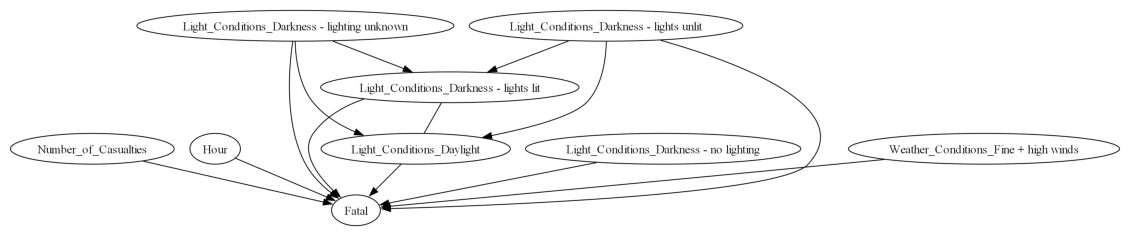

finish
CPU times: total: 2.19 s
Wall time: 1.82 s


In [52]:
%%time
cg = pc(data_traff_df.dropna().values[:700,:9], 0.05, fisherz, False, 0,-1)  # Run PC and obtain the estimated graph (CausalGraph object)
pyd = GraphUtils.to_pydot(cg.G,labels=data_traff_df.columns[:9])
tmp_png = pyd.create_png(f="png")
fp = io.BytesIO(tmp_png)
img = mpimg.imread(fp, format='png')
plt.figure(figsize = (20,20))
plt.axis('off')
plt.imshow(img)
plt.show()
print('finish')